In [ ]:
!pip install torchmetrics
!pip install thop
!pip install kornia

In [ ]:
#import

import zipfile
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from thop import profile, clever_format

import torch.nn as nn
import torch.optim as optim

from torchmetrics import JaccardIndex
import torch.nn.functional as F
import random

from tqdm import tqdm

import kornia

import time
from models.model_utils import BasicBlock, Bottleneck, segmenthead, DAPPM, PAPPM, PagFM, Bag, Light_Bag
import logging

In [ ]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

--2025-01-05 18:02:53--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2025-01-05 18:02:54--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip.1’

Train.zip.1         100%[===================>]   3.75G  19.1MB/s    in 3m 33s  

2025-01-05 18:06:27 (18.0 MB/s) - ‘Train.zip.1’ saved [4021669263/4021669263]

--2025-01-05 18:06:27--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP requ

In [ ]:
!wget https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar

In [ ]:
# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")

# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))

Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


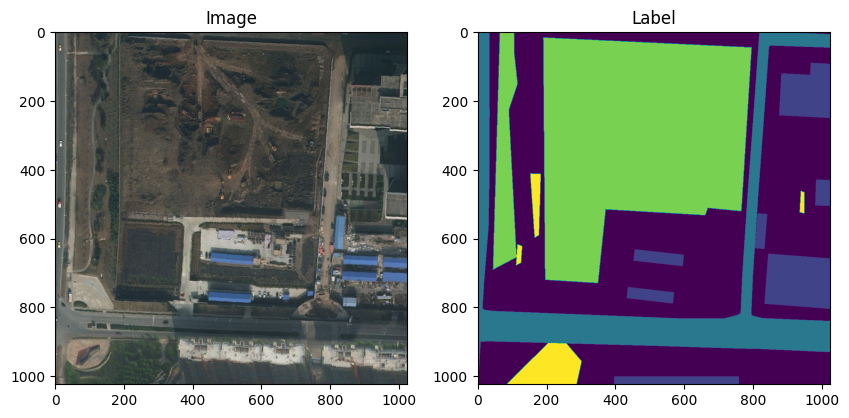

In [ ]:
# Load and visualize an image and its corresponding label
image_path = "Train/Train/Urban/images_png/1366.png"
label_path = "Train/Train/Urban/masks_png/1366.png"

image = Image.open(image_path)
label = Image.open(label_path)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label)
plt.show()

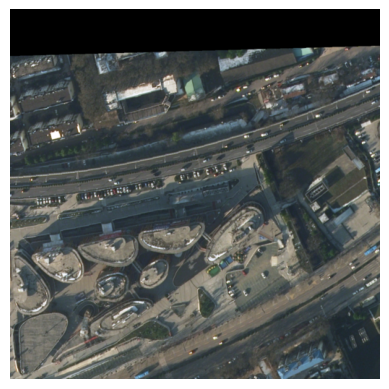

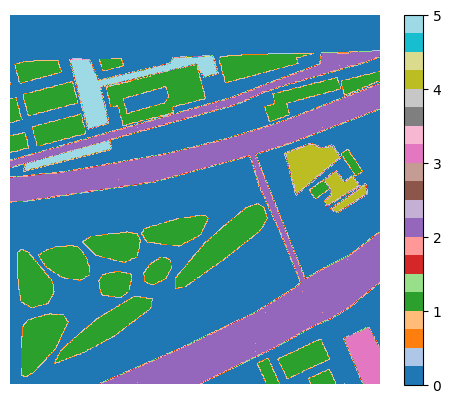

In [ ]:
#TASK 3.b

COLOR_MAP = {
    'Background': 0.00392157,
    'Building': 0.00784314,
    'Road': 0.01176471,
    'Water': 0.01568628,
    'Barren': 0.01960784,
    'Forest': 0.02352941,
    'Agricultural': 0.02745098
}

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    mask = np.asarray(mask, dtype=np.float32)
    if len(mask.shape) == 2:  # Ensure channel dimension exists
        mask = np.expand_dims(mask, axis=0)  # Convert [H, W] to [1, H, W]

    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

def show_mask(mask_tensor, num_classes=7):
    """ Display the mask using matplotlib. """
    # Convert the one-hot mask to the label mask (indices of the highest value per pixel)
    mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
    label_mask = np.argmax(mask, axis=0)  # Get the class index with the highest value for each pixel

    plt.imshow(label_mask, cmap='tab20')  # Use a colormap suitable for categorical data
    plt.colorbar()  # Optionally add a color bar
    plt.axis('off')  # Hide axes
    plt.show()


def colorJitter(colorJitter, img_mean, data = None, target = None, s=0.25):
    # s is the strength of colorjitter
    #colorJitter
    if not (data is None):
        if data.shape[1]==3:
            if colorJitter > 0.2:
                img_mean, _ = torch.broadcast_tensors(img_mean.unsqueeze(0).unsqueeze(2).unsqueeze(3), data)
                seq = nn.Sequential(kornia.augmentation.ColorJitter(brightness=s,contrast=s,saturation=s,hue=s))
                data = (data+img_mean)/255
                data = seq(data)
                data = (data*255-img_mean).float()
    return data, target

def gaussian_blur(blur, data = None, target = None):
    if not (data is None):
        if data.shape[1]==3:
            if blur > 0.5:
                sigma = np.random.uniform(0.15,1.15)
                kernel_size_y = int(np.floor(np.ceil(0.1 * data.shape[2]) - 0.5 + np.ceil(0.1 * data.shape[2]) % 2))
                kernel_size_x = int(np.floor(np.ceil(0.1 * data.shape[3]) - 0.5 + np.ceil(0.1 * data.shape[3]) % 2))
                kernel_size = (kernel_size_y, kernel_size_x)
                seq = nn.Sequential(kornia.filters.GaussianBlur2d(kernel_size=kernel_size, sigma=(sigma, sigma)))
                data = seq(data)
    return data, target

def strongTransform(parameters, data=None, target=None):
    assert ((data is not None) or (target is not None))
    # data, target = transformsgpu.oneMix(mask = parameters["Mix"], data = data, target = target)
    data, target = colorJitter(colorJitter = parameters["ColorJitter"], img_mean = torch.from_numpy(IMG_MEAN.copy()).cuda(), data = data, target = target)
    data, target = gaussian_blur(blur = parameters["GaussianBlur"], data = data, target = target)
    # data, target = transformsgpu.flip(flip = parameters["flip"], data = data, target = target)
    return data, target


class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None, subdir="Rural", aug1=False, aug2=False):
        self.root_dir = root_dir
        self.split = split
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.aug1 = aug1
        self.aug2 = aug2
        self.image_paths = []
        self.label_paths = []

        image_dir = os.path.join(root_dir, split, subdir, 'images_png')
        label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

        for f in os.listdir(image_dir):
            if f.endswith('.png'):
                self.image_paths.append(os.path.join(image_dir, f))
                self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        original_length = len(self.image_paths)
        if self.aug1 and self.aug2:
            return original_length * 2
        elif self.aug1 or self.aug2:
            return int(original_length * 1.5)
        else:
            return original_length


    def __getitem__(self, idx):
        original_length = len(self.image_paths)

        # Calcola l'indice originale nel dataset
        idx = idx % original_length

        aug_1 = False
        aug_2 = False
        if(idx < original_length):
            aug_1 = False
            aug_2 = False

        elif(idx >= original_length):
            if(random.random() < 0.5):
                if(self.aug1):
                    aug_1 = True
                    aug_2 = False
                elif(self.aug2):
                    aug_1 = False
                    aug_2 = True
                    
            else:
                if (self.aug2):
                    aug_1 = False
                    aug_2 = True
                elif(self.aug1):
                    aug_1 = True
                    aug_2 = False


        # Carica l'immagine e la maschera
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = Image.open(self.label_paths[idx]).convert("L")

        image_np = np.array(image)
        label_np = np.array(label)

        # Seed per garantire coerenza tra immagine e maschera
        seed = np.random.randint(2147483647)

        # Applica augmentazione se abilitata
        if self.aug1 and aug_1:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            transform_aug1 = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30)
            ])
            image = Image.fromarray(image_np)
            image = transform_aug1(image)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            label = transform_aug1(label)
            label_np = np.array(label)

        if self.aug2 and aug_2:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            # transform_aug2 = transforms.Compose([
            #     #sigma=(0.1, 5) indica un intervallo di valori tra 0.1 e 5, quindi la sfocatura potrebbe variare in base a come viene applicata.
            #     transforms.GaussianBlur(kernel_size=(5,9), sigma=( 0.1, 5)) #valori di dimensioni (5, 9), che significa che il filtro si estende su un'area di 5x9 pixel.
            # ])
            strong_parameters = {}
            strong_parameters["ColorJitter"] = random.uniform(0, 1)
            strong_parameters["GaussianBlur"] = random.uniform(0, 1)


            image = Image.fromarray(image_np)
            image, _ = strongTransform(strong_parameters, image, None)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            # label = transform_aug2(label)
            label_np = np.array(label)

        # Trasformazioni opzionali per immagine e maschera
        if self.transform_image:
            transform_image_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = Image.fromarray(image_np)
            image = transform_image_alb(image)

        if self.transform_label:
            transform_label_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
            ])
            label = Image.fromarray(label_np)
            label = transform_label_alb(label).squeeze(0)
            label = color_to_one_hot(label, LABEL_MAP)

        return image,label

# Define transformations without augmentations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

transform_label = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Set augmentation flags
AUG1 = True
AUG2 = False

BATCH_SIZE = 16 #or 32, or 64 ...
NUM_WORKERS = 2 # Number of cpu cores
PIN_MEMORY = True
PERSISTENT_WORKERS = False # Set true if you have persistent workers issues
# Create dataset and dataloader with augmentations
train_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label, subdir='Urban', aug1=AUG1, aug2=AUG2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)


val_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label, subdir='Rural')
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Visualize the first batch of images
for i, (image, label) in enumerate(train_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        show_mask(label[0])
        break


# # Definisci una dimensione più piccola per il subset (ad esempio 10% del dataset)
# subset_size = 100  # Usa solo i primi 100 campioni per il test

# # Usa torch.utils.data.Subset per ottenere un subset casuale dei dati
# subset_indices = torch.randperm(len(train_loader.dataset)).tolist()[:subset_size]
# train_subset = torch.utils.data.Subset(train_loader.dataset, subset_indices)

# # Crea un DataLoader per il subset
# #DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
# train_subset_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
# for i, (image, label) in enumerate(train_subset_loader):
#     if i == 0:  # Show only the first batch
#         show_image(image[0])  # Access the first image of the batch
#         show_mask(label[0])
#         break


Visualizing image 1


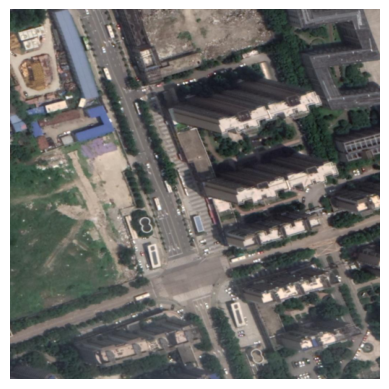

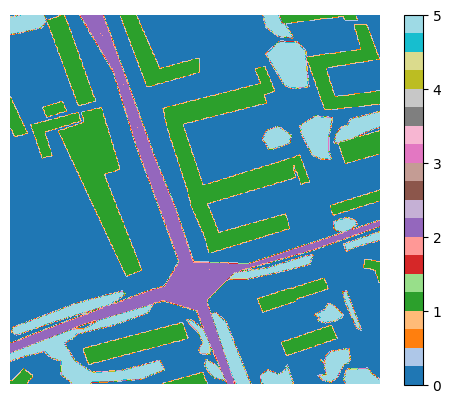

In [ ]:
# Funzione per visualizzare immagini con augmentations applicate
def visualize_augmented_images(dataloader, num_images=1):
    """
    Visualizza immagini con augmentations applicate.
    Args:
        dataloader: Il DataLoader dal quale prelevare le immagini.
        num_images: Numero di immagini da visualizzare.
    """
    count = 0
    for images, labels in dataloader:
        for i in range(images.size(0)):
            if count >= num_images:
                return  # Mostra solo il numero richiesto di immagini
            print(f"Visualizing image {count + 1}")
            show_image(images[i])  # Visualizza l'immagine
            show_mask(labels[i])  # Visualizza la maschera
            count += 1

# Visualizza immagini con augmentations dal train_loader
visualize_augmented_images(train_loader, num_images=1)

In [ ]:
!git clone https://github.com/XuJiacong/PIDNet.git
%cd content

Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 35.54 MiB/s, done.
Resolving deltas: 100% (184/184), done.
/content/PIDNet


In [ ]:
import sys
sys.path.append('/content/PIDNet')

In [ ]:

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_


def get_seg_model(name, num_classes, imgnet_pretrained, model_pth):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=True)



    if imgnet_pretrained:
        # print("vamos")
        pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        # print(len(pretrained_state))
        # print(len(model_dict))
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        # print('Attention!!!')
        # print(msg)
        # print('Over!!!')
        model.load_state_dict(model_dict, strict = False)
        # print("done")
    else:
        # print("vamos")

        pretrained_dict = torch.load(model_pth, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_seg_model(name='pidnet_s', num_classes=7, imgnet_pretrained=True, model_pth='PIDNet_S_ImageNet.pth.tar').to(device)




In [ ]:
num_classes=7

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define mIoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=7).to('cuda')  # intersection over union. Directly measures the overlap between predicted segmentation and ground truth.


# Training loop
num_epochs = 20 #20
best_miou = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") # train_loader
    for images, masks in train_progress_bar:
        images, masks = images.to(device), masks.to(device)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        outputs = model(images)
        main_output = outputs[1]

        # Upsample model outputs to match the target resolution (512x512)
        outputs_resized = F.interpolate(main_output, size=(masks.shape[2], masks.shape[3]), mode='bilinear', align_corners=False)

        # Ensure masks are in the right shape and type (long)
        masks = masks.squeeze(1)  # Remove extra channel dimension and convert to long

        # Calculate loss
        loss = criterion(outputs_resized, masks)  # Use CrossEntropyLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm progress bar with real-time loss using set_postfix
        train_progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_loader) #len(train_subset_loader) #len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {avg_loss:.4f}")

    # Clear GPU memory
    torch.cuda.empty_cache()

    # Validation loop
    model.eval()
    val_miou = 0.0
    val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class
    val_class_counts = torch.zeros(len(LABEL_MAP)).to('cuda')  # To track number of pixels for each class

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to('cuda'), masks.to('cuda')

            # Forward pass
            outputs = model(images)  # [batch_size, num_classes, 64, 64]
            main_output = outputs[1]
            preds = torch.argmax(main_output, dim=1)  # [batch_size, 64, 64]

            # Convert masks to class indices format if one-hot encoded
            if masks.ndim == 4:  # [batch_size, num_classes, height, width]
                masks = masks.argmax(dim=1)  # [batch_size, height, width]

            # Resize preds to match the size of the masks
            preds_resized = F.interpolate(preds.unsqueeze(1).float(), size=masks.shape[1:], mode='nearest').squeeze(1).long()

            # Calculate per-class IoU
            for c, class_name in LABEL_MAP.items():  # Iterate over LABEL_MAP classes
                true_class = (masks == class_name)
                pred_class = (preds_resized == class_name)

                intersection = torch.sum(true_class & pred_class).float()
                union = torch.sum(true_class | pred_class).float()

                if union != 0:
                    val_class_iou[class_name] += intersection / union
                val_class_counts[class_name] += 1

            # Calculate overall mIoU for this batch
            val_miou += jaccard(preds_resized, masks)

    # Average metrics
    val_miou /= len(val_loader)

    # Calculate average IoU for each class
    avg_class_iou = val_class_iou / val_class_counts

    # Print validation metrics at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation mIoU: {val_miou:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] - Per-Class IoU: {dict(zip(LABEL_MAP.keys(), avg_class_iou.tolist()))}")

    # Save the best model
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), 'best_pidnet_model.pth')

print(f"Best Validation mIoU: {best_miou:.4f}")


Epoch 1/20: 100%|██████████| 109/109 [02:18<00:00,  1.27s/batch, loss=1.3268]

Epoch [1/20] Loss: 1.1788


Epoch [1/20] - Validation mIoU: 0.0935
Epoch [1/20] - Per-Class IoU: {'Background': 0.37326204776763916, 'Building': 0.17760702967643738, 'Road': 0.021294046193361282, 'Water': 0.04303314536809921, 'Barren': 0.008799140341579914, 'Forest': 0.03028176911175251, 'Agricultural': 0.00026764371432363987}


Epoch 2/20: 100%|██████████| 109/109 [02:14<00:00,  1.23s/batch, loss=1.0490]

Epoch [2/20] Loss: 1.0885


Epoch [2/20] - Validation mIoU: 0.0970
Epoch [2/20] - Per-Class IoU: {'Background': 0.323739230632782, 'Building': 0.17827406525611877, 'Road': 0.00992359034717083, 'Water': 0.13099800050258636, 'Barren': 0.0013607315486297011, 'Forest': 0.0336473248898983, 'Agricultural': 0.0009842297295108438}


Epoch 3/20: 100%|██████████| 109/109 [02:16<00:00,  1.25s/batch, loss=1.0489]

Epoch [3/20] Loss: 1.0276


Epoch [3/20] - Validation mIoU: 0.1453
Epoch [3/20] - Per-Class IoU: {'Background': 0.26221561431884766, 'Building': 0.23305873572826385, 'Road': 0.01749800145626068, 'Water': 0.17685161530971527, 'Barren': 0.10889575630426407, 'Forest': 0.13148975372314453, 'Agricultural': 0.08711623400449753}


Epoch 4/20: 100%|██████████| 109/109 [02:15<00:00,  1.25s/batch, loss=1.2807]


Epoch [4/20] Loss: 0.9928
Epoch [4/20] - Validation mIoU: 0.1225
Epoch [4/20] - Per-Class IoU: {'Background': 0.2935270071029663, 'Building': 0.16146717965602875, 'Road': 0.04233561456203461, 'Water': 0.1928812712430954, 'Barren': 0.06309923529624939, 'Forest': 0.0636754035949707, 'Agricultural': 0.040726643055677414}


Epoch 5/20: 100%|██████████| 109/109 [02:15<00:00,  1.24s/batch, loss=1.0194]


Epoch [5/20] Loss: 0.9461
Epoch [5/20] - Validation mIoU: 0.1489
Epoch [5/20] - Per-Class IoU: {'Background': 0.3322729170322418, 'Building': 0.1925947219133377, 'Road': 0.05942998081445694, 'Water': 0.18483565747737885, 'Barren': 0.04118145629763603, 'Forest': 0.036599114537239075, 'Agricultural': 0.1951722800731659}


Epoch 6/20: 100%|██████████| 109/109 [02:16<00:00,  1.25s/batch, loss=0.8446]


Epoch [6/20] Loss: 0.9090
Epoch [6/20] - Validation mIoU: 0.1421
Epoch [6/20] - Per-Class IoU: {'Background': 0.33081257343292236, 'Building': 0.22414591908454895, 'Road': 0.07499228417873383, 'Water': 0.24765560030937195, 'Barren': 0.011387460865080357, 'Forest': 0.08229948580265045, 'Agricultural': 0.0234699510037899}


Epoch 7/20: 100%|██████████| 109/109 [02:15<00:00,  1.24s/batch, loss=0.7671]


Epoch [7/20] Loss: 0.8651
Epoch [7/20] - Validation mIoU: 0.1717
Epoch [7/20] - Per-Class IoU: {'Background': 0.36150920391082764, 'Building': 0.23687441647052765, 'Road': 0.13786572217941284, 'Water': 0.22271929681301117, 'Barren': 0.038111019879579544, 'Forest': 0.055073197931051254, 'Agricultural': 0.15003062784671783}


Epoch 8/20: 100%|██████████| 109/109 [02:16<00:00,  1.25s/batch, loss=0.8307]


Epoch [8/20] Loss: 0.8536
Epoch [8/20] - Validation mIoU: 0.1582
Epoch [8/20] - Per-Class IoU: {'Background': 0.3818259537220001, 'Building': 0.27176058292388916, 'Road': 0.07985810935497284, 'Water': 0.25248390436172485, 'Barren': 0.024987945333123207, 'Forest': 0.059183601289987564, 'Agricultural': 0.037625525146722794}


Epoch 9/20: 100%|██████████| 109/109 [02:14<00:00,  1.23s/batch, loss=0.8655]

Epoch [9/20] Loss: 0.8208


Epoch [9/20] - Validation mIoU: 0.1682
Epoch [9/20] - Per-Class IoU: {'Background': 0.3392890691757202, 'Building': 0.2122306376695633, 'Road': 0.16373805701732635, 'Water': 0.21935269236564636, 'Barren': 0.08115659654140472, 'Forest': 0.06671217083930969, 'Agricultural': 0.0946725532412529}


Epoch 10/20: 100%|██████████| 109/109 [02:15<00:00,  1.24s/batch, loss=0.8783]


Epoch [10/20] Loss: 0.8205
Epoch [10/20] - Validation mIoU: 0.1434
Epoch [10/20] - Per-Class IoU: {'Background': 0.38006770610809326, 'Building': 0.1276579648256302, 'Road': 0.17968443036079407, 'Water': 0.14070379734039307, 'Barren': 0.0482986681163311, 'Forest': 0.025269636884331703, 'Agricultural': 0.10183780640363693}


Epoch 11/20: 100%|██████████| 109/109 [02:19<00:00,  1.28s/batch, loss=0.9355]


Epoch [11/20] Loss: 0.7738
Epoch [11/20] - Validation mIoU: 0.1452
Epoch [11/20] - Per-Class IoU: {'Background': 0.35098251700401306, 'Building': 0.14611609280109406, 'Road': 0.1269640475511551, 'Water': 0.2564948797225952, 'Barren': 0.048370808362960815, 'Forest': 0.07146567851305008, 'Agricultural': 0.016176776960492134}


Epoch 12/20: 100%|██████████| 109/109 [02:15<00:00,  1.24s/batch, loss=0.8400]

Epoch [12/20] Loss: 0.7528


Epoch [12/20] - Validation mIoU: 0.1579
Epoch [12/20] - Per-Class IoU: {'Background': 0.3496986925601959, 'Building': 0.16546666622161865, 'Road': 0.11769784986972809, 'Water': 0.25610172748565674, 'Barren': 0.04181313514709473, 'Forest': 0.06619637459516525, 'Agricultural': 0.10856398195028305}


Epoch 13/20: 100%|██████████| 109/109 [02:15<00:00,  1.24s/batch, loss=0.5850]

Epoch [13/20] Loss: 0.7290


Epoch [13/20] - Validation mIoU: 0.1723
Epoch [13/20] - Per-Class IoU: {'Background': 0.4226236045360565, 'Building': 0.20497451722621918, 'Road': 0.13139963150024414, 'Water': 0.20561864972114563, 'Barren': 0.07856281101703644, 'Forest': 0.022667596116662025, 'Agricultural': 0.1403653770685196}


Epoch 14/20: 100%|██████████| 109/109 [02:15<00:00,  1.24s/batch, loss=0.7338]

Epoch [14/20] Loss: 0.6892


Epoch [14/20] - Validation mIoU: 0.1655
Epoch [14/20] - Per-Class IoU: {'Background': 0.3700576722621918, 'Building': 0.21028460562229156, 'Road': 0.1605416089296341, 'Water': 0.2530633211135864, 'Barren': 0.060550253838300705, 'Forest': 0.05518638715147972, 'Agricultural': 0.04873793572187424}


Epoch 15/20: 100%|██████████| 109/109 [02:16<00:00,  1.25s/batch, loss=0.7270]


Epoch [15/20] Loss: 0.6669
Epoch [15/20] - Validation mIoU: 0.1659
Epoch [15/20] - Per-Class IoU: {'Background': 0.4523598849773407, 'Building': 0.21479734778404236, 'Road': 0.12384159862995148, 'Water': 0.2472853809595108, 'Barren': 0.035152602940797806, 'Forest': 0.01778101921081543, 'Agricultural': 0.06997085362672806}


Epoch 16/20: 100%|██████████| 109/109 [02:17<00:00,  1.26s/batch, loss=0.6778]

Epoch [16/20] Loss: 0.6495


Epoch [16/20] - Validation mIoU: 0.2047
Epoch [16/20] - Per-Class IoU: {'Background': 0.4565768539905548, 'Building': 0.31867101788520813, 'Road': 0.22283637523651123, 'Water': 0.2554411292076111, 'Barren': 0.044565748423337936, 'Forest': 0.05240815505385399, 'Agricultural': 0.08264003694057465}


Epoch 17/20: 100%|██████████| 109/109 [02:15<00:00,  1.24s/batch, loss=0.6507]

Epoch [17/20] Loss: 0.6456


Epoch [17/20] - Validation mIoU: 0.1609
Epoch [17/20] - Per-Class IoU: {'Background': 0.3894456923007965, 'Building': 0.19094690680503845, 'Road': 0.19446690380573273, 'Water': 0.18417362868785858, 'Barren': 0.049253590404987335, 'Forest': 0.009549794718623161, 'Agricultural': 0.10850808769464493}


Epoch 18/20: 100%|██████████| 109/109 [02:16<00:00,  1.25s/batch, loss=0.7034]

Epoch [18/20] Loss: 0.5940


Epoch [18/20] - Validation mIoU: 0.1875
Epoch [18/20] - Per-Class IoU: {'Background': 0.3962146043777466, 'Building': 0.22552619874477386, 'Road': 0.2171378880739212, 'Water': 0.2561871409416199, 'Barren': 0.05289056897163391, 'Forest': 0.11106089502573013, 'Agricultural': 0.053243525326251984}


Epoch 19/20: 100%|██████████| 109/109 [02:16<00:00,  1.25s/batch, loss=0.7993]


Epoch [19/20] Loss: 0.5703
Epoch [19/20] - Validation mIoU: 0.2328
Epoch [19/20] - Per-Class IoU: {'Background': 0.43752074241638184, 'Building': 0.27985090017318726, 'Road': 0.2615952789783478, 'Water': 0.2595057189464569, 'Barren': 0.052149903029203415, 'Forest': 0.10258643329143524, 'Agricultural': 0.23633317649364471}


Epoch 20/20: 100%|██████████| 109/109 [02:15<00:00,  1.24s/batch, loss=0.5150]


Epoch [20/20] Loss: 0.5562
Epoch [20/20] - Validation mIoU: 0.2202
Epoch [20/20] - Per-Class IoU: {'Background': 0.45707347989082336, 'Building': 0.28660598397254944, 'Road': 0.2254994958639145, 'Water': 0.2699398100376129, 'Barren': 0.06803136318922043, 'Forest': 0.10084260255098343, 'Agricultural': 0.13375358283519745}
Best Validation mIoU: 0.2328



Random Sample (Epoch 6)
Input Tensor:  torch.Size([1, 3, 512, 512])
Ground Truth:  torch.Size([7, 512, 512])
Model Output:  torch.Size([1, 7, 64, 64])


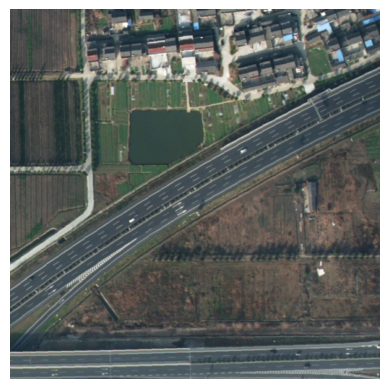

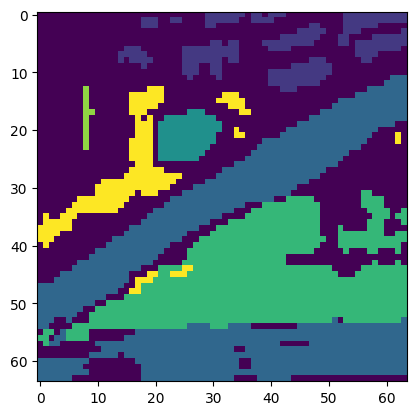

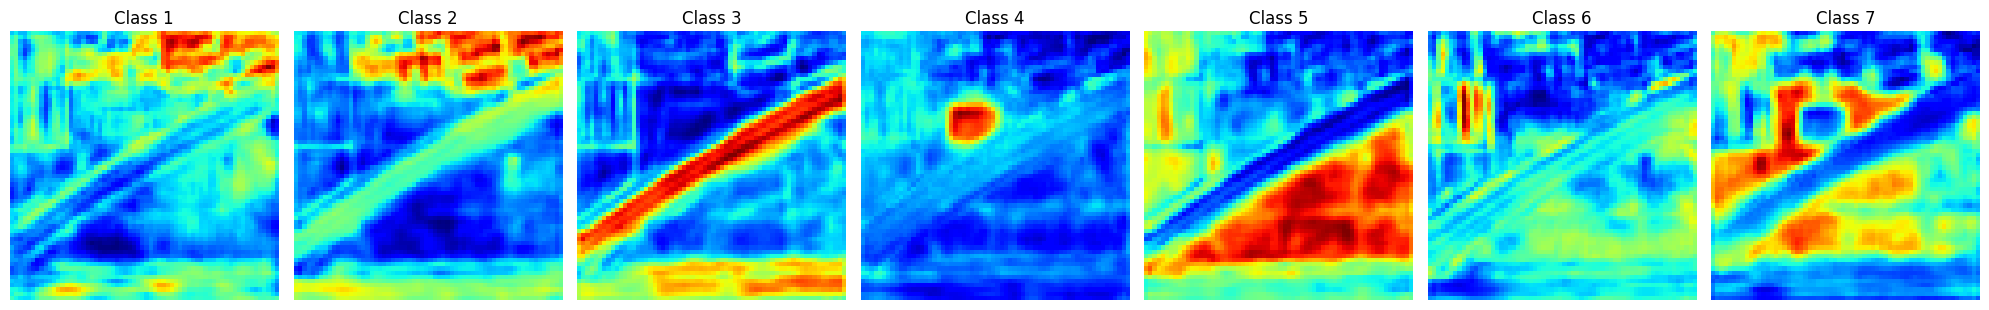

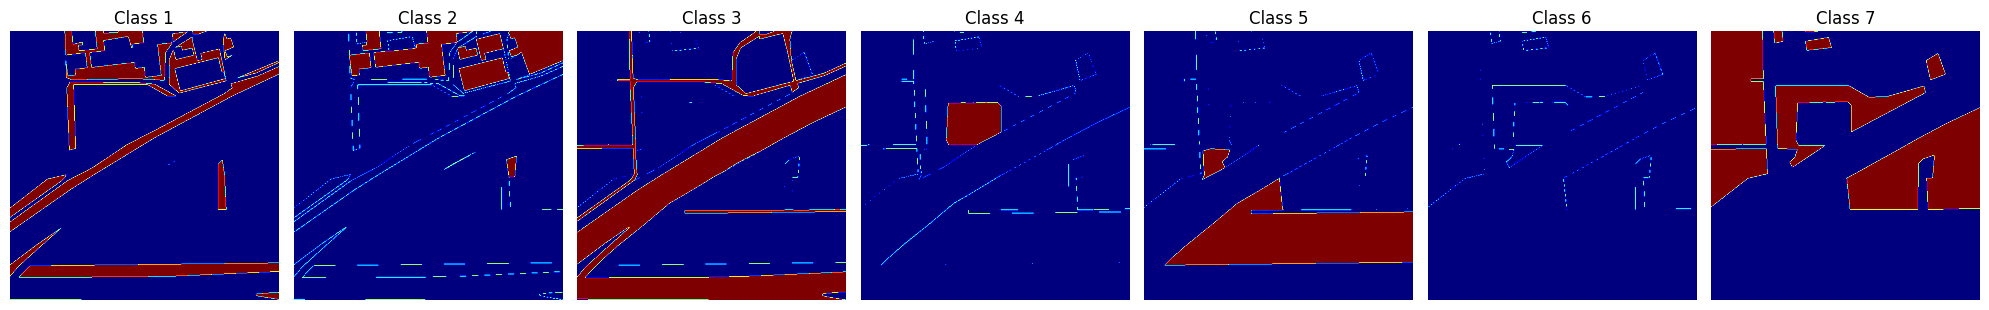

In [ ]:
TRAINING=1
if TRAINING:  # Ensure you have a condition for training mode
    # Pick a random batch from the train loader
    a, b = val_dataset[330]
    inputs, targets = a, b  # Assuming the loader returns (input, target) pairs

    # Move the inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.unsqueeze(0)  # Add a batch dimension

    # Get the model output for the input
    model.eval()  # Make sure the model is in evaluation mode
    with torch.no_grad():
        output = model(inputs)  # Get model prediction for the input

    # Print the random input, output, and ground truth
    print("\nRandom Sample (Epoch {})".format(i))
    print("Input Tensor: ", inputs.shape)
    print("Ground Truth: ", targets.shape)
    print("Model Output: ", output.shape)

    # print(type(a))
    # plt.imshow(a.permute(1,2,0).numpy()) #image
    show_image(a)
    # print(b.argmax(dim=1).shape)
    plt.imshow(b.argmax(dim=0)) #grouth truth mask

    output = output.squeeze(0)
    # print(output.argmax(dim=0).shape)
    plt.imshow(output.cpu().argmax(dim=0).numpy()) #

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = output[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = targets[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    model.train()